In [3]:
# ---------------------------------------------------------------------
# 모델링 관련 모듈 로딩
# ---------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchinfo import summary

from torchmetrics.regression import R2Score, MeanSquaredError
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import MulticlassConfusionMatrix
import torch.optim.lr_scheduler as lr_scheduler

import torchvision.models as models

# ---------------------------------------------------------------------
# 데이터 분석 관련 모듈 로딩
# ---------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 이미지 관련 모듈 로딩
# ---------------------------------------------------------------------
import cv2
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2

# ---------------------------------------------------------------------
# 기타 모듈 로딩
# ---------------------------------------------------------------------
import time
import os

# ---------------------------------------------------------------------
# 커스텀 모듈 로딩
# ---------------------------------------------------------------------
import OpenCV_func

# 활용 패키지 버전 체크
print(f'torch Ver.:{torch.__version__}')
print(f'pandas Ver.:{pd.__version__}')
print(f'numpy Ver.:{np.__version__}')

torch Ver.:2.4.1
pandas Ver.:2.0.3
numpy Ver.:1.24.3


In [4]:
# DEVICE 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

- 이미지 파일 => 하나로 합치기 <hr>

In [5]:
## 이미지 파일 => 하나로 합치기
## 데이터 관련 설정
IMG_PATH = './test_image/'

- Tensor ==> Ndarray <hr>

In [6]:
## 데이터 변형 및 전처리
transConvert = v2.Compose([
    v2.Resize([256, 256]),
    v2.RandomResizedCrop(224),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.ToDtype(torch.float32, scale=True)
])

c:\Users\KDP-50\anaconda3\envs\TORCH_CV_38\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [7]:
## 이미지 데이터셋 생성
imgDS=ImageFolder(root=IMG_PATH, transform=transConvert)

In [8]:
print(f'imgDS2.classes       : {imgDS.classes}')
print(f'imgDS2.class_to_idx  : {imgDS.class_to_idx}')
print(f'imgDS2.targets       : {imgDS.targets}')
for img in imgDS.imgs:
    print(f'imgDS.imgs       : {img}')

imgDS2.classes       : ['apple', 'banana', 'orange', 'strawberry']
imgDS2.class_to_idx  : {'apple': 0, 'banana': 1, 'orange': 2, 'strawberry': 3}
imgDS2.targets       : [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3]
imgDS.imgs       : ('./test_image/apple\\FreshApple (1).jpg', 0)
imgDS.imgs       : ('./test_image/apple\\FreshApple (2).jpg', 0)
imgDS.imgs       : ('./test_image/apple\\FreshApple (3).jpg', 0)
imgDS.imgs       : ('./test_image/apple\\FreshApple (4).jpg', 0)
imgDS.imgs       : ('./test_image/apple\\freshApple (1).png', 0)
imgDS.imgs       : ('./test_image/banana\\Banana__Healthy_augmented_21.jpg', 1)
imgDS.imgs       : ('./test_image/banana\\Banana__Healthy_augmented_22.jpg', 1)
imgDS.imgs       : ('./test_image/banana\\Banana__Healthy_augmented_23.jpg', 1)
imgDS.imgs       : ('./test_image/banana\\Banana__Healthy_augmented_24.jpg', 1)
imgDS.imgs       : ('./test_image/banana\\Banana__Healthy_augmented_26.jpg', 1)
imgDS.imgs       : ('./test_image/orange\\fre

In [9]:
# imgDL=DataLoader(imgDS, batch_size=32)

In [10]:
# train, test 분리

# 모듈 로딩
from torch.utils.data import random_split
trainDS, validDS, testDS = random_split(imgDS, [15, 3, 2])

trainDL=DataLoader(trainDS, batch_size=32)
validDL=DataLoader(validDS, batch_size=32)
testDL=DataLoader(testDS, batch_size=32)

In [11]:
# for data, target in imgDL:
#     print(data.shape)
#     print(target.shape)
#     break

In [12]:
### 사전학습된 모델 로딩
model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)

In [13]:
### 모델 구조 확인 
# print(model)
# summary(model)

In [14]:
### 사전학습된 모델의 파라미터 비활성화 설정
for named, param in model.named_parameters():
    # print(f'[{named}] - {param.shape}')
    
    # 역전파 시에 업데이트 되지 않도록 설정
    param.requires_grad=False

In [15]:
model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 4)
)

In [16]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [17]:
### classifier 파라미터 활성화 설정
for named, param in model.classifier[6].named_parameters():
    print(f'[{named}] - {param.shape}')
    param.requires_grad=True

[0.weight] - torch.Size([512, 4096])
[0.bias] - torch.Size([512])
[3.weight] - torch.Size([4, 512])
[3.bias] - torch.Size([4])


In [18]:
model=model.to(DEVICE)

In [19]:
# print(model)

In [20]:
# 최적화 인스턴스
optimizer = torch.optim.Adam(model.classifier[6].parameters(), lr=0.01)

# 손실함수 인스턴스
loss_func = torch.nn.CrossEntropyLoss()

# 최적화 스케쥴링 인스턴스 생성 => lr 조절 및 성능 개선 여부 체크
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True) # score 사용 시


c:\Users\KDP-50\anaconda3\envs\TORCH_CV_38\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [21]:
def train_model(model, loss_func, optimizer, num_epochs=1, is_train=True):
    since = time.time()
    loss_history = [],[]
    acc_history = [],[]
    best_acc = 0.0
    num_epochs = 5

    for epoch in range(num_epochs):
        # 학습 모드로 모델 설정
        model.train()

        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        running_corrects = 0
        running_loss = 0.0
        
        score_total = 0

        for featureTS, targetTS in trainDL:

            # DEVICE : CPU/GPU 사용
            featureTS=featureTS.to(DEVICE)
            targetTS=targetTS.to(DEVICE)
            
            # 학습 진행
            pre_y = model(featureTS)

            # 손실 계산
            loss = loss_func(pre_y, targetTS)

            # # 예제 점수계산법
            _, preds = torch.max(pre_y, 1)

            # 성능평가 계산
            score=MulticlassF1Score(num_classes=4)(pre_y, targetTS.reshape(-1))
            score_total += score.item()

            # 최적화 진행
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_corrects += torch.sum(preds == targetTS.data)
            running_loss += loss.item() * featureTS.size(0) # loss값 * batch_size

        # 검증 모드로 모델 설정
        model.eval()

        running_val_corrects = 0
        running_val_loss = 0.0
        
        with torch.no_grad():
            # 검증 데이터셋
            for feature, target in validDL:

                # CPU/GPU 사용
                feature=feature.to(DEVICE)
                target=target.to(DEVICE)

                # 평가
                pre_val=model(feature)

                # 손실
                # loss_val=loss_func(pre_val, target.reshape(-1).long())
                loss_val=loss_func(pre_val, target)

                # 성능평가
                # score_val=MulticlassF1Score(num_classes=4)(pre_val, target.reshape(-1))
                score_val=MulticlassF1Score(num_classes=4)(pre_val, target)
            
            running_val_corrects+=score_val.item()
            running_val_loss+=loss_val.item()

        with torch.no_grad():
            # 테스트 데이터셋
            for test_feature, test_target in testDL:
                test_feature=test_feature.to(DEVICE)
                test_target=test_target.to(DEVICE)

                # 평가
                pre_test=model(test_feature)

                # 손실
                loss_test=loss_func(pre_test, test_target).to(DEVICE)

                # 성능평가
                score_test=MulticlassF1Score(num_classes=4).to(DEVICE)(pre_test, test_target)

        epoch_acc = running_corrects.double() / len(trainDL)
        epoch_loss = running_loss

        EPOCH_LOSS = epoch_loss/len(trainDL)
        SCORE_LOSS = score_total/len(trainDL)

        print('[TRAIN] LOSS: {:.4f} SCORE: {:.4f}'.format(EPOCH_LOSS, SCORE_LOSS)) 
        print('[VAL] LOSS: {:.4f} SCORE: {:.4f}'.format(running_val_loss, running_val_corrects))
        print('[TEST] LOSS: {:.4f} SCORE: {:.4f}'.format(loss_test, score_test))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        loss_history[0].append(EPOCH_LOSS)        
        acc_history[0].append(SCORE_LOSS)

        loss_history[1].append(running_val_loss)
        acc_history[1].append(running_val_corrects)

        ### 모델 저장 부분
        # 끝나는 시간 저장
        end_time = time.strftime('%y.%m.%d..%H_%M_%S')

        FILE_PATH= './YH_models_param'

        # 파일 경로 만들기
        if not os.path.exists(FILE_PATH):
            os.mkdir(FILE_PATH)
        else:
            pass

        # 모델 파라미터 저장
        if len(acc_history[1]) == 1:
            torch.save(model.state_dict(), os.path.join(FILE_PATH, '{0:0=2d}_{1}.pth'.format(epoch+1, end_time)))
        else:
            if acc_history[1][-1] > max(acc_history[1][:-1]):
                torch.save(model.state_dict(), os.path.join(FILE_PATH, '{0:0=2d}_{1}.pth'.format(epoch+1, end_time)))
        print()

        # 모델 파라미터 저장
        if len(acc_history[1]) == 1:
            torch.save(model.state_dict(), os.path.join('./models/', '{0:0=2d}_{1}.pth'.format(epoch+1, end_time)))
        else:
            if acc_history[1][-1] > max(acc_history[1][:-1]):
                torch.save(model.state_dict(), os.path.join('./models/', '{0:0=2d}_{1}.pth'.format(epoch+1, end_time)))
        print()

        # 모델 경로 지정
        SAVE_PATH = './YH_models'

        # 파일 경로 만들기
        if not os.path.exists(SAVE_PATH):
            os.mkdir(SAVE_PATH)
        else:
            pass
        
        # 모델 이름 설정
        SAVE_MODEL = f'/model_num_loss({epoch_loss:.4f})_score({score_total:.4f})'
        

        # 모델 전체 저장
        if len(acc_history[1]) == 1:
            torch.save(model, SAVE_PATH+SAVE_MODEL)
        else:
            if acc_history[1][-1] > max(acc_history[1][:-1]):
                torch.save(model, SAVE_PATH+SAVE_MODEL)

        # 최적화 스케쥴러 인스턴스 업데이트
        scheduler.step(loss_val)
        print(f'scheduler.num_bad_epochs => {scheduler.num_bad_epochs}', end=' ')
        print(f'scheduler.patience => {scheduler.patience}')

        # 손실 감소(또는 성능 개선)이 안되는 경우 조기종료
        if scheduler.num_bad_epochs >= scheduler.patience:
            print(f'{scheduler.patience}EPOCH 성능 개선이 없어서 조기종료함')
            break

    time_elapsed = time.time() - since
    print('모델 학습 시간: {:.0f}분 {:.0f}초'.format(time_elapsed // 60, time_elapsed % 60))
    return loss_history, acc_history

In [22]:
loss_history, acc_history = train_model(model, loss_func, optimizer, num_epochs=1, is_train=True)

Epoch 1/5
----------
[TRAIN] LOSS: 20.7981 SCORE: 0.1429
[VAL] LOSS: 2.2007 SCORE: 0.5000
[TEST] LOSS: 2.7522 SCORE: 0.3333


scheduler.num_bad_epochs => 0 scheduler.patience => 5
Epoch 2/5
----------
[TRAIN] LOSS: 8.4415 SCORE: 0.8333
[VAL] LOSS: 0.0034 SCORE: 1.0000
[TEST] LOSS: 0.0000 SCORE: 1.0000


scheduler.num_bad_epochs => 1 scheduler.patience => 5
Epoch 3/5
----------
[TRAIN] LOSS: 10.9717 SCORE: 0.7937
[VAL] LOSS: 0.0000 SCORE: 1.0000
[TEST] LOSS: 0.0000 SCORE: 1.0000


scheduler.num_bad_epochs => 2 scheduler.patience => 5
Epoch 4/5
----------
[TRAIN] LOSS: 11.1727 SCORE: 0.9286
[VAL] LOSS: 0.0000 SCORE: 1.0000
[TEST] LOSS: 0.0000 SCORE: 1.0000


scheduler.num_bad_epochs => 3 scheduler.patience => 5
Epoch 5/5
----------
[TRAIN] LOSS: 0.0256 SCORE: 1.0000
[VAL] LOSS: 0.0000 SCORE: 1.0000
[TEST] LOSS: 0.0000 SCORE: 1.0000


scheduler.num_bad_epochs => 4 scheduler.patience => 5
모델 학습 시간: 0분 31초


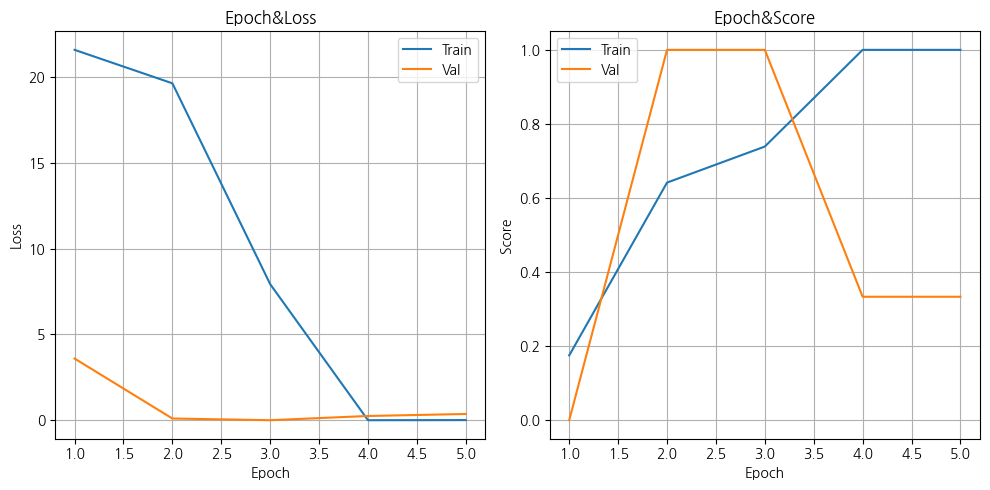

In [22]:
OpenCV_func.loss_score_plot(loss_history, acc_history, threshold=5)

In [25]:
MulticlassConfusionMatrix()

[TEST] LOSS: 4.059306621551514 SCORE: 0.3333333432674408
